In [1]:
import mindquantum as mq
import mindspore as ms
import mindspore.context as context
from mindquantum.algorithm.nisq.chem import Transform, get_qubit_hamiltonian, uccsd_singlet_generator, uccsd_singlet_get_packed_amplitudes
from mindquantum.core.operators import TimeEvolution
from mindquantum.core import Circuit
from mindquantum.framework import MQAnsatzOnlyLayer
from mindspore.common.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
context.set_context(mode=context.PYNATIVE_MODE, device_target="CPU")

In [3]:
def hamiltonian(coeff):
    a, b, c, d, e, f = coeff
    h = mq.QubitOperator('', a) + mq.QubitOperator("Z0", b) + mq.QubitOperator("Z1", c) + mq.QubitOperator("Z0 Z1", d) + mq.QubitOperator("Y0 Y1", e) + mq.QubitOperator("X0 X1", f)
    return mq.Hamiltonian(h)

In [4]:
dd = np.loadtxt("./pea_table_formatted0.txt")

In [5]:
all_coeff = dd[:, 1:7]

In [6]:
dist = dd[:, 0]

Create ansata circuit

In [7]:
# Initial Hartree_Fock state
hf = Circuit()
hf += mq.X.on(0)
# Create ansatz circuit
u = mq.QubitOperator("X0 Y1", 't')
ansatz_circuit = TimeEvolution(u, 1.0).circuit

In [8]:
total_circuit = hf + ansatz_circuit
total_circuit

q0: ─────X───────H────●─────────────────●───────H──────
                      │                 │
q1: ──RX(π/2)─────────X────RZ(2.0*t)────X────RX(7π/2)──

In [9]:
total_circuit.summary()

========Circuit Summary========
|Total number of gates  : 12. |
|Parameter gates        : 1.  |
|with 1 parameters are  : t.  |
|Number qubit of circuit: 2   |


In [10]:
def plot_scatter(x, y):
    plt.figure(facecolor='w')
    plt.minorticks_on()
    plt.scatter(x, y, marker='s', label="VQE")
    plt.xlabel("Bond Length "r"$R$")
    plt.ylabel("Total Energy(hartree)")
    plt.legend()
    #plt.title("Energy surface of molecular hydrogen as determined by VQE")
    plt.savefig("H2 energy.svg")
    return None

In [11]:
def vqe(total_circuit, all_coeff, dist, init_amp=[0.0]):
    #all_iter_list = []; 
    Ei_min_list = []
    for _, coeff in enumerate(all_coeff):
        hh = hamiltonian(coeff)
        grad_ops = mq.Simulator("projectq", total_circuit.n_qubits).get_expectation_with_grad(hh, total_circuit)
        pqcent = MQAnsatzOnlyLayer(grad_ops)
        pqcent.weight = Parameter(ms.Tensor(init_amp, pqcent.weight.dtype) )
        
        init_E = pqcent()
        
        optimzer = ms.nn.Adagrad(pqcent.trainable_params(), learning_rate=4e-2)
        train_pqcent = ms.nn.TrainOneStepCell(pqcent, optimzer)
        
        eps = 1.e-8
        E_diff = eps * 1e3
        E_last = init_E.asnumpy() + E_diff
        
        iter_idx = 0
        #iter_list = []
        Ei_list = []
        
        
        while abs(E_diff) > eps:
            Ei = train_pqcent().asnumpy()
        
            if iter_idx % 5 == 0:
                #iter_list.append(iter_idx)
                Ei_list.append(Ei)
            E_diff = E_last - Ei
            E_last = Ei
            iter_idx += 1
        #all_iter_list.append(iter_list)
        Ei_min_list.append(min(Ei_list) )
    plot_scatter(dist, Ei_min_list)
    
    return None

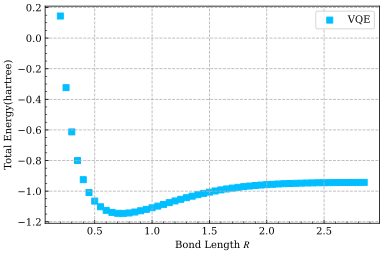

In [12]:
vqe(total_circuit, all_coeff, dist)